In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.6 MB/s eta 0:00:00


In [32]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

class FeaturePredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=None):
        super().__init__()
        if output_dim is None:
            output_dim = input_dim

        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim // 2)
        self.predictor = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x, edge_index):
        # Graph convolutions
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv3(x, edge_index))

        # Feature prediction
        return self.predictor(x)

In [30]:
class DigitalInequalityForecaster:
    def __init__(self, data, pivot_df, n_clusters=5):
        self.data = data
        self.pivot_df = pivot_df
        self.n_clusters = n_clusters
        self.model = None
        self.scaler = StandardScaler()
        self.country_year_to_idx = self._create_country_year_mapping()

    def _create_country_year_mapping(self):
        """Create mapping: (country, year) -> node_index"""
        mapping = {}
        for idx, row in self.pivot_df.iterrows():
            mapping[(row['Economy'], row['Year'])] = idx
        return mapping

    def get_node_idx(self, country, year):
        return self.country_year_to_idx.get((country, year))

    def prepare_training_pairs(self, train_years):
        """We are preparing pairs (current_year, next_year) for training"""
        training_pairs = []

        for country in self.pivot_df['Economy'].unique():
            country_data = self.pivot_df[self.pivot_df['Economy'] == country].sort_values('Year')
            years = country_data['Year'].tolist()

            for i in range(len(years) - 1):
                current_year = years[i]
                next_year = years[i + 1]

                # We check that both years are in the training period.
                if current_year in train_years and next_year in train_years:
                    current_idx = self.get_node_idx(country, current_year)
                    next_idx = self.get_node_idx(country, next_year)

                    if current_idx is not None and next_idx is not None:
                        training_pairs.append((current_idx, next_idx))

        return training_pairs

    def train_feature_predictor(self, train_years, epochs=501, lr=0.001):
        """We are training a feature prediction model"""
        print("Preparing data for training...")
        training_pairs = self.prepare_training_pairs(train_years)
        print(f"Found {len(training_pairs)} pairs for training...")

        if len(training_pairs) == 0:
            raise ValueError("No suitable pairs have been found for training!")

        input_dim = self.data.x.shape[1]
        self.model = FeaturePredictor(input_dim=input_dim)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

        print("Training start...")
        self.model.train()

        for epoch in range(epochs):
            total_loss = 0
            batch_count = 0

            # Mini-batches for learning stability
            for i in range(0, len(training_pairs), 32):
                batch_pairs = training_pairs[i:i+32]
                if not batch_pairs:
                    continue

                optimizer.zero_grad()
                batch_loss = 0

                # Predicted features
                predicted_features = self.model(self.data.x, self.data.edge_index)

                # Calculate loss for batch
                for current_idx, next_idx in batch_pairs:
                    batch_loss += F.mse_loss(predicted_features[current_idx],
                                           self.data.x[next_idx])

                batch_loss = batch_loss / len(batch_pairs)
                batch_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += batch_loss.item()
                batch_count += 1

            avg_loss = total_loss / batch_count if batch_count > 0 else total_loss
            scheduler.step(avg_loss)

            if epoch % 50 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'Epoch {epoch:03d}, Loss: {avg_loss:.6f}, LR: {current_lr:.6f}')


    def predict_future_features(self, target_year, current_year=2023):
        """Predicting features for the target year"""
        if self.model is None:
            raise ValueError("The model is not trained! First, call train_feature_predictor")

        self.model.eval()

        print(f"Predict the features for {target_year} year...")

        # We get the latest available data for each country
        latest_data = {}
        country_indices = []

        for country in self.pivot_df["Economy"].unique():
            country_data = self.pivot_df[self.pivot_df["Economy"] == country]
            if current_year in country_data['Year'].values:
                current_idx = self.get_node_idx(country, current_year)
                latest_data[country] = self.data.x[current_idx].clone()
                country_indices.append(current_idx)
            else:
                # If there is no data for current_year, we take the last available year.
                latest_year = country_data['Year'].max()
                latest_idx = self.get_node_idx(country, latest_year)
                latest_data[country] = self.data.x[latest_idx].clone()
                country_indices.append(latest_idx)

        if not country_indices:
            raise ValueError("No prediction data was found!")

        selected_nodes = torch.tensor(country_indices, dtype=torch.long)

        # Creating a new graph with only the selected nodes
        subgraph_data = self._create_subgraph(selected_nodes)

        # Iterative prediction
        years_ahead = target_year - current_year
        if years_ahead <= 0:
            raise ValueError("The target year must be longer than the current one!")

        current_features = torch.stack([latest_data[country] for country in latest_data.keys()])

        print(f"Making a prediction for {years_ahead} years ahead...")
        print(f"Subgraph size: {current_features.shape[0]} nodes, {subgraph_data.edge_index.shape[1]} edges")

        with torch.no_grad():
            for year in range(years_ahead):
                # We use the subgraph for prediction
                predicted = self.model(current_features, subgraph_data.edge_index)
                current_features = predicted

                if (year + 1) % 1 == 0:
                    print(f"  Year {current_year + year + 1} was predicted")

        return current_features, list(latest_data.keys())

    def _create_subgraph(self, selected_nodes):
        """Creates a subgraph for selected nodes only"""
        from torch_geometric.utils import subgraph

        # We filter the connections, leaving only those where both nodes are in selected_nodes.
        node_mask = torch.zeros(self.data.x.size(0), dtype=torch.bool)
        node_mask[selected_nodes] = True

        # Create a subgraph
        sub_edge_index, _ = subgraph(
            node_mask,
            self.data.edge_index,
            relabel_nodes=True,  # Relabelling nodes from 0
            num_nodes=self.data.x.size(0)
        )

        # Create Data object for subgraph
        subgraph_data = Data(
            x=self.data.x[selected_nodes],  # Chosen edges only
            edge_index=sub_edge_index
        )

        return subgraph_data

    def cluster_with_gcn(self, future_features, countries, gcn_model):
        """Clustering using a trained GCN"""
        print("Clustering using a trained GCN...")

        device = next(gcn_model.parameters()).device

        with torch.no_grad():
            gcn_model.eval()

            temp_data = self._create_temp_graph(future_features, countries)

            # We use GCN on the time graph
            embeddings = gcn_model(temp_data.x.to(device), temp_data.edge_index.to(device))
            predicted_clusters = embeddings.argmax(dim=1).cpu().numpy()
            confidence_scores = F.softmax(embeddings, dim=1).max(dim=1)[0].cpu().numpy()

        results_df = pd.DataFrame({
            'Country': countries,
            'Predicted_Cluster': predicted_clusters,
            'Confidence': confidence_scores
        })

        cluster_counts = results_df['Predicted_Cluster'].value_counts().sort_index()
        print(f"\nClusters distribution (GCN):")
        for cluster_id, count in cluster_counts.items():
            cluster_countries = results_df[results_df['Predicted_Cluster'] == cluster_id]['Country'].tolist()
            avg_conf = results_df[results_df['Predicted_Cluster'] == cluster_id]['Confidence'].mean()
            print(f"Cluster {cluster_id}: {count} countries (conf: {avg_conf:.3f})")
            print(f"  Examples: {cluster_countries[:6]}")

        return results_df

    def _create_temp_graph(self, features, countries):
        """Creates a temporary graph with only the predicted nodes."""
        from torch_geometric.data import Data
        import networkx as nx
        from sklearn.metrics.pairwise import cosine_similarity

        features_np = features.cpu().numpy()
        n_nodes = len(features_np)

        # Create similarity-based graph
        print("Creating a temporary graph based on cosine similarity...")

        # Calculating the cosine similarity
        similarity_matrix = cosine_similarity(features_np)

        # Creating edges based on similarity (top 5 neighbors for each node)
        edges = []
        for i in range(n_nodes):
            # We take the indexes of the top 5 most similar nodes (excluding the node itself)
            similarities = similarity_matrix[i]
            similarities[i] = -1  # исключаем сам узел
            top_indices = np.argsort(similarities)[-5:]  # top 5

            for j in top_indices:
                if similarities[j] > 0.3:  # similarity threshold
                    edges.append((i, j))
                    edges.append((j, i))  # an undirected graph

        if not edges:
            # If there are no edges, create a minimal connected graph
            print("Creating a minimal connected graph...")
            for i in range(n_nodes - 1):
                edges.append((i, i + 1))
                edges.append((i + 1, i))

        # Convert to edge_index
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        else:
            # If there are no edges at all, create self-loops
            edge_index = torch.tensor([[i for i in range(n_nodes)],
                                    [i for i in range(n_nodes)]], dtype=torch.long)

        print(f"A temporary graph has been created: {n_nodes} nodes, {edge_index.shape[1]} edges")

        return Data(x=features, edge_index=edge_index)

    def evaluate_on_historical(self, test_year=2023, train_years=None):
        """Model evaluation based on historical data"""
        if train_years is None:
            train_years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

        print(f"Model evaluation: train on {min(train_years)}-{max(train_years)}, test on {test_year}")

        # Train on data before test_year-1
        self.train_feature_predictor([y for y in train_years if y < test_year])

        # Predict test_year
        predicted_features, countries = self.predict_future_features(test_year, test_year-1)

        # Compare it with real data - ONLY for countries that have data for test_year
        real_features = []
        valid_countries = []
        valid_predicted_features = []

        for i, country in enumerate(countries):
            real_idx = self.get_node_idx(country, test_year)
            if real_idx is not None:
                real_features.append(self.data.x[real_idx].cpu().numpy())
                valid_predicted_features.append(predicted_features[i].cpu().numpy())
                valid_countries.append(country)

        if real_features:
            real_features = np.array(real_features)
            valid_predicted_features = np.array(valid_predicted_features)

            print(f"Compare the predictions for {len(valid_countries)} countries with real data")

            # Calculate MSE
            mse = np.mean((real_features - valid_predicted_features) ** 2)
            print(f"MSE for {test_year} year: {mse:.6f}")

            # Additional metrics - Mean Absolute Error
            mae = np.mean(np.abs(real_features - valid_predicted_features))
            print(f"MAE for {test_year} year: {mae:.6f}")

            # Metrics for individual features
            feature_mse = np.mean((real_features - valid_predicted_features) ** 2, axis=0)
            print(f"Best feature MSE: {np.min(feature_mse):.6f}, Worst feature MSE: {np.max(feature_mse):.6f}")

            return mse, valid_predicted_features, real_features, valid_countries

        print("There is no real data to compare!")
        return None, predicted_features, None, countries

In [31]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

Data downloading...
GCN модель загружена!
pivot_df shape: (734, 64)
Countries: 99
Years: [np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]
Countries with data in 2023: 68
=== STAGE 1: VALIDATION BASED ON HISTORICAL DATA ===
Model evaluation: train on 2014-2022, test on 2023
Preparing data for training...
Found 524 pairs for training...
Training start...
Epoch 000, Loss: 0.537773, LR: 0.001000
Epoch 050, Loss: 0.240574, LR: 0.001000
Epoch 100, Loss: 0.213763, LR: 0.001000
Epoch 150, Loss: 0.201695, LR: 0.001000
Epoch 200, Loss: 0.177534, LR: 0.001000
Epoch 250, Loss: 0.163847, LR: 0.001000
Epoch 300, Loss: 0.150411, LR: 0.001000
Epoch 350, Loss: 0.145807, LR: 0.001000
Epoch 400, Loss: 0.137697, LR: 0.001000
Epoch 450, Loss: 0.129529, LR: 0.001000
Epoch 500, Loss: 0.128702, LR: 0.001000
Predict the features for 2023 year...
Making a prediction for 1 years ahead..

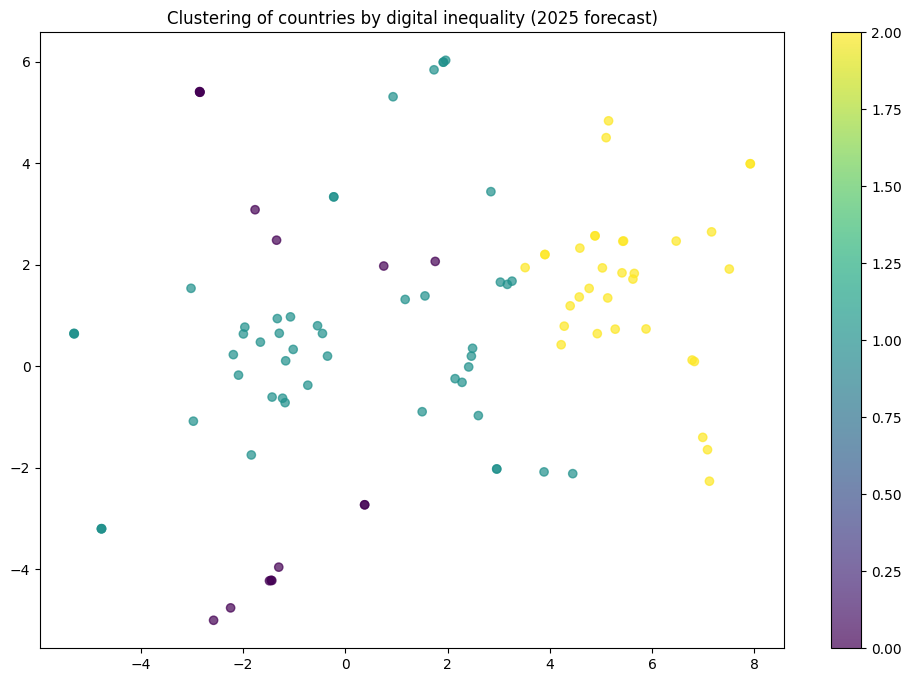

          Country  Predicted_Cluster  Confidence
0         Albania                  0    0.998931
1         Algeria                  2    1.000000
2         Armenia                  2    1.000000
3         Austria                  1    1.000000
4      Azerbaijan                  2    1.000000
..            ...                ...         ...
94  United States                  2    1.000000
95        Uruguay                  2    1.000000
96     Uzbekistan                  1    0.999999
97       Viet Nam                  2    1.000000
98       Zimbabwe                  2    1.000000

[99 rows x 3 columns]


In [ ]:
# Download the data
print("Data downloading...")
data = torch.load("../digital_inequality_graph.pt", weights_only=False)
df = pd.read_csv("../cleaned_final_dataset.csv")

gcn_model = torch.load("../models/simple_gcn_model.pth", weights_only=False)
print("GCN model was uploaded!")

pivot_df = df.pivot_table(
    index=["Economy", "Year"],
    columns="Indicator",
    values="Value"
).reset_index()

# Add node_id field
pivot_df["node_id"] = range(len(pivot_df))

print(f"pivot_df shape: {pivot_df.shape}")
print(f"Countries: {pivot_df['Economy'].nunique()}")
print(f"Years: {sorted(pivot_df['Year'].unique())}")

# Checking the data for 2023
countries_2023 = pivot_df[pivot_df['Year'] == 2023]['Economy'].unique()
print(f"Countries with data in 2023: {len(countries_2023)}")

# Create a forecaster
forecaster = DigitalInequalityForecaster(data, pivot_df, n_clusters=5)

# Stage 1: val based on historial data (2014-2024 years)
print("=== STAGE 1: VALIDATION BASED ON HISTORICAL DATA ===")
mse, pred_features, real_features, countries = forecaster.evaluate_on_historical(test_year=2023)

# Stage 2: learning from all the data
print("\n=== STAGE 2: LEARNING FROM ALL THE DATA ===")
all_train_years = list(range(2014, 2024))  # Все годы с данными
forecaster.train_feature_predictor(all_train_years)

# Stage 3: future prediction
print("\n=== STAGE 3: PREDICTING FUTURE CLUSTERS ===")
future_features, countries = forecaster.predict_future_features(target_year=2025)

# Stage 4: clustering
results_df = forecaster.cluster_with_gcn(future_features, countries, gcn_model)

# Save the results
results_df.to_csv("../future_clusters_2025.csv", index=False)
print(f"\nSaved results in future_clusters_2025.csv")
print(f"Cluster distribution:")
print(results_df['Predicted_Cluster'].value_counts().sort_index())

# Visualization of results
try:
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE

    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(future_features.cpu().numpy())

    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                          c=results_df['Predicted_Cluster'], cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title('Clustering of countries by digital inequality (2025 forecast)')
    plt.savefig('../future_clusters_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

except ImportError:
    print("Install matplotlib and scikit-learn for visualization.")

print(forecaster)
print(results_df)